# Tarea 3 - Logistic Regression, classification, Metropolis-Hastings and Monte Carlo

In [41]:
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal, uniform

### Data generation

First we need to generate the data. We will use the make moons dataset creation tool from sklearn to create our dataset.

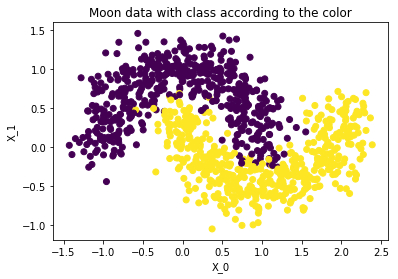

<Figure size 432x288 with 0 Axes>

In [371]:
# generate data
noise = 0.2
n_samples = 1000
percent_test = 0.2
sklearn.datasets
X, y = sklearn.datasets.make_moons(n_samples=n_samples, shuffle=True, noise=noise)
# X, y = sklearn.datasets.make_blobs(n_samples=n_samples, shuffle=True, centers=2, cluster_std=7)

# divide test and train dataset
idx_sep = int(n_samples*percent_test)
X_train, y_train = X[idx_sep:,:], y[idx_sep:]
X_test, y_test = X[:idx_sep,:], y[:idx_sep]

# visualize data
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Moon data with class according to the color")
plt.xlabel("X_0")
plt.ylabel("X_1")
plt.show()

### Logistic Regression

We will perform a logistic regression to create a model that fit the data and that is capable of classify the data.

The model is $y = \sigma(\omega^T \tilde{X})$. $\sigma$ is the logistic function $\sigma(x) = \dfrac{1}{1+\exp(-x)}$. $\omega \in \mathbb{R}^3$ is the parameter we wish to find. $\tilde{X} = [X, 1]^T$ where $X \in \mathbb{R}^2$. So when the model is trained, we can give an input $X$ and the model returns us the probability that the point belongs to the first class. How do we train the model ?

We wish to maximize the posterior distribution :

$p(\omega | X, y) \quad \alpha \quad p(y | X, \omega) p(\omega)$

We have $p(y | X, \omega) = \displaystyle \prod_{i=1}^N p(y_i | \omega, X_i) = \displaystyle \prod_{i=1}^N p(i \in C_1 | \omega, X_i)^{y_i} p(i \in C_2 | \omega, X_i)^{1-y_i} = \displaystyle \prod_{i=1}^N \sigma(\omega^T \tilde{X_i})^{y_i} (1-\sigma(\omega^T \tilde{X_i}))^{1-y_i}$

We suppose a prior as a multivariate normal distribution : 

$p(\omega) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma|}}\exp{(-\dfrac{1}{2}(\omega-\mu)^T\Sigma^{-1}(\omega-\mu))}$

We choose $\mu = [0, 1, 0]$ because we have the line $X_1 = -\dfrac{\omega_0}{\omega_1}X_0-\dfrac{\omega_2}{\omega_1}$ and at first glance, I expect to get something like $X_1 = \epsilon_0 X_0+\epsilon_1$ with $\epsilon_0$ and $\epsilon_1$ as small positive real number. We choose $\Sigma = \beta \times I$ with a certain $\beta$ value. We guess that a uniform distribution is not a good choice because there must a be a higher probability for a certain value of $\omega$. Concerning the covariance matrix, it is dificult to suppose anything in particular, so we will just simply suppose that there is no correlation at all between values because we have no idea (covariance matrix diagonal and let a medium variance for the value).

We want to minimize $NLL(\omega) = -\log(p(\omega | X, y)) \equiv - \displaystyle \sum_{i=1}^N y_i \log(\sigma(\omega^T \tilde{X_i})) + (1-y_i)(\log(1-\sigma(\omega^T \tilde{X_i}))) + \dfrac{1}{2}\displaystyle\sum_{i=0}^2 \dfrac{(\omega_i-\mu_i)^2}{\sigma_i^2}$.

In [8]:
def toXtilde(X):
    X_tilde = np.zeros((X.shape[0], X.shape[1]+1))
    for i in range(0, X_tilde.shape[0]):
        X_tilde[i] = [X[i, 0], X[i, 1], 1]
    return X_tilde

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [112]:
def nll(omega, X, y, mu_prior, beta_prior):
    n_samples_X = X.shape[0]
    
    # generative part
    array_sum = np.zeros(n_samples_X)
    epsilon = 10**(-8)
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        array_sum[i] = y[i]*np.log(sigmoid_value+epsilon) + (1-y[i])*np.log(1-sigmoid_value+epsilon)
        
    # prior part
    prior_part = (1/(2*beta_prior**2))*np.sum((omega-mu_prior)**2)
    
    # nll total 
    nll = -np.sum(array_sum)+ prior_part
    return nll

In [113]:
def jac_nll(omega, X, y, mu_prior, beta_prior):
    n_samples_X = X.shape[0]
    jac_nll = np.zeros(3)
    epsilon = 10**(-8)
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        jac_nll += (sigmoid_value - y[i])*np.array([X[i,0], X[i,1], 1])
    jac_nll += 2*(omega-mu_prior)
    return jac_nll

In [114]:
initial_guess_omega = [0.5, 1.3, 1]
beta_prior = 5
mu_prior = np.array([0, 1, 0])
result_opt = scipy.optimize.minimize(fun=nll,
                                     jac=jac_nll,
                                     x0=initial_guess_omega, 
                                     args=(X_train, y_train, mu_prior, beta_prior), 
                                     method="L-BFGS-B")

omega_opt = result_opt.x
print("omega opt :", omega_opt)

omega opt : [ 1.23777398 -3.67217864  0.22268697]


In [377]:
def visualizeLine(omega=omega_opt, legend=True, display_omega=True):
    if display_omega:
        print("omega optimal used :", omega)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, label="Test data")
    t = np.linspace(-1.5, 2.2, 2)
    plt.plot(t, -t*omega[0]/omega[1]-omega[2]/omega[1], label="Separation line")
    if legend:
        plt.legend()
    plt.title("Moon test data and its separation line")
    plt.xlabel("X_0")
    plt.ylabel("X_1")
    plt.ylim(top=1.5, bottom=-1.0)

omega optimal used : [ 1.23777398 -3.67217864  0.22268697]


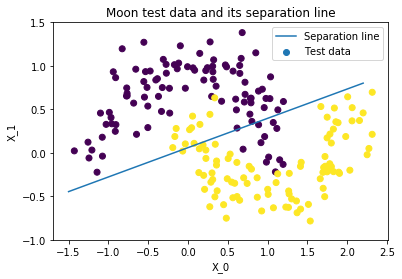

In [378]:
visualizeLine()

Now we want to evaluate our model using the test data.

In [116]:
def predict(X, w_opt, threshold=0.5):
    """
        Arguments:
            X (array) : input
            w_opt (array) : optimal parameter of the model
            threshold (float) : separation to choose between class one and two
            
        Returns: 
            y_pred (int) : 0 or 1
    """
    y_float_pred = sigmoid(np.matmul(w_opt[0:2], X.T) + w_opt[2])
    y_pred = [1 if val >= threshold else 0 for val in y_float_pred]
    return y_pred

In [327]:
def evaluateModel(y_pred_test):
    acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    auc = roc_auc_score(y_true=y_test, y_score=y_pred_test)
    print("Accuracy =", acc, "\n conf_mat =", conf_mat, "\n auc = ", auc)

In [328]:
y_pred_test = predict(X=X_test, w_opt=omega_opt)
evaluateModel(y_pred_test=y_pred_test)

Accuracy = 0.83 
 conf_mat = [[80 15]
 [19 86]] 
 auc =  0.8305764411027569


### Metropolis Hasting Sampling of the posterior

Now we wish to extract sample for the posterior distribution. In order to acheive this we are going to use a MCMC method.

$p(y | X, \omega) \equiv \displaystyle \prod_{i=1}^N \sigma(\omega^T \tilde{X_i})^{y_i} (1-\sigma(\omega^T \tilde{X_i}))^{1-y_i} \times \dfrac{1}{\sqrt{(2\pi)^3|\Sigma|}} \exp{(-\dfrac{1}{2}\displaystyle\sum_{i=0}^2 \dfrac{(\omega_i-\mu_i)^2}{\sigma_i^2})} $

In [150]:
def posterior(omega, X, y, mu_prior=mu_prior, beta_prior=beta_prior):
    n_samples_X = X.shape[0]
    
    # generative part
    posterior = 1
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        if y[i] == 0:
            posterior *= (1-sigmoid_value)
        else:
            posterior *= sigmoid_value
        
    # prior part
    prior_part = np.exp(-(1/(2*beta_prior**2))*np.sum((omega-mu_prior)**2))
    
    # nll total 
    posterior *= prior_part
    return posterior

In [169]:
class ProposalDensity:
    
    def __init__(self, name):
        self.name = name
        
        self.variance_uniform = 5
        self.cov_normal = 3*np.identity(3)
        
    def density_valuation(self, w_new, w_before):
        
        if self.name == "normal":
            return multivariate_normal.pdf(x=w_new, mean=w_before, cov=self.cov_normal)
        
        elif self.name == "uniform":
            return uniform.pdf(x=w_new, loc=np.mean(w_before)-self.variance_uniform/2, scale=self.variance_uniform)
        
    def sample(self, w_before):
        
        if self.name == "normal":
            return multivariate_normal.rvs(mean=w_before, cov=self.cov_normal, size=1)
        
        elif self.name == "uniform":
            return np.array([uniform.rvs(x=w_new, loc=w_before[i]-self.variance_uniform/2, scale=self.variance_uniform) for i in range(3)])

In [199]:
def metropolis_hastings_sample(proposal_name, n_generate_sample, w0):
    
    proposal = ProposalDensity(name=proposal_name)
    epsilon = 10**(-7)
    nb_samples = 0
    stock_sample = np.zeros(shape=(n_generate_sample, len(w0)))
    w_c = w0
    max_iter = 0
    while nb_samples < n_generate_sample and max_iter < 100000:
        
        w_t = proposal.sample(w_before=w_c)
#         print("old - new", w_c, w_t)
        
        r1 = (nll(omega=w_t, X=X_train, y=y_train, mu_prior=mu_prior, beta_prior=beta_prior)*proposal.density_valuation(w_new=w_c, w_before=w_t))
#         print("r1", r1)
        
        r2 = (nll(omega=w_c, X=X_train, y=y_train, mu_prior=mu_prior, beta_prior=beta_prior)*proposal.density_valuation(w_new=w_t, w_before=w_c))
#         print("r2", r2)
        
        r = r1/(r2+epsilon)
        
        u = uniform.rvs(size=1, loc=0, scale=1)
#         print("Accept = ",u, r, "\n")
        
        if u[0] < r:
            w_c = w_t
            stock_sample[nb_samples] = w_c
            nb_samples += 1
        max_iter += 1
    
    return stock_sample

In [200]:
omega_initial = np.array([-0.5, 1, -0.7])
mh_samples = metropolis_hastings_sample(proposal_name="normal", n_generate_sample=1000, w0=omega_opt)

#### Histograms of parameters

After creating the samples, we can get the histograms of every parameters.

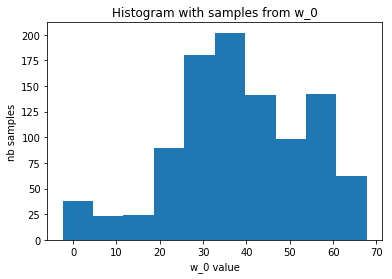

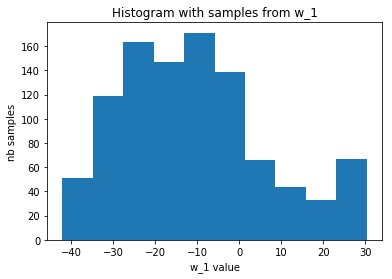

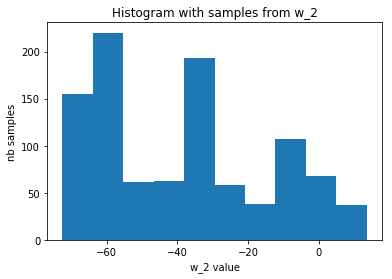

In [304]:
for i in range(3):
    plt.hist(mh_samples[:, i]) #, range=(-10, 10))
    plt.title("Histogram with samples from w_"+str(i))
    plt.xlabel("w_"+str(i)+" value")
    plt.ylabel("nb samples")
    plt.show()

#### Visualize lines from sampled parameters

We now would like to visualize some of the lines from the samples and see if it makes sense.

index = 173
index = 265
index = 492
index = 780
index = 181


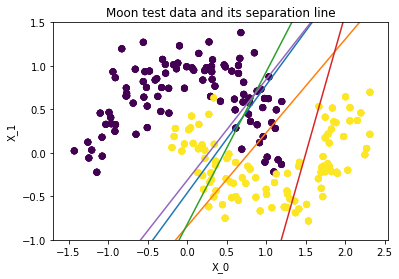

In [395]:
nb_lines_to_visualize = 5
for _ in range(nb_lines_to_visualize):
    index_sample = np.random.randint(1000)
    print("index =", index_sample)
    visualizeLine(omega=mh_samples[index_sample, :], legend=False, display_omega=False)

In [305]:
# other interestng optimal omega find by metropolis
[ 66.43977976, -35.82231341, -27.36447535] #index = 497
[ 36.6619578,  -39.72626242, -20.3167275 ] #index = 248
[ 36.29779858, -24.45519556, -16.15014347] #index = 161
[ 42.44834964, -18.57463705, -10.05529414] #index = 213 looks good really
[ 65.95563463, -33.92884471, -29.72740209] #index = 503 looks really good too
[ 22.35934289,  24.75036987, -46.59949423] #index = 902 insanely bad

# get the mean value for omega form MH
omega_mean_mh = np.mean(mh_samples, axis=0) # not good ~

### Monte Carlos Integral for predictions

We have that :

$p(y_* | x_*, X, Y) = \int p(y_* | x_*, \omega)p(\omega| X, Y)d\omega = E_{\omega| X, Y}[p(y_* | x_*, \omega)] \simeq \dfrac{1}{n}\displaystyle\sum_{i=1}^{n} p(y_* | x_*, \omega) = \dfrac{1}{n}\displaystyle\sum_{i=1}^{n} \sigma(\omega_i^T \tilde{x_*})$

Where the elements $\omega_i$ are generated from the posterior distribution $p(\omega| X, Y)$.

In [358]:
def monte_carlos_prediction(w_samples, X, thinning_step=200, burnin=0, threshold=0.5):
    """
        Arguments:
            w_samples (array) : shape (n_samples, 3)
            X (array) : get prediction out of this array
            thinning_step (float) : step to extract samples for calculating the integral
                with a smaller autocorrelation between parameters
            burnin (float) : number of fisrt values to NOT consider in w_samples
            
        Returns:
            y_pred (array) : prediction for each element in X_to_predict
    """
    n_pred = X.shape[0]
    w_samples_used = np.array([param for i, param in enumerate(w_samples[burnin:]) if i%thinning_step == 0])
    y_pred = np.zeros(n_pred)
    for i in range(n_pred):
        y_pred[i] = np.mean(sigmoid(np.matmul(w_samples_used[:, :2], X[i, :].T) + w_samples_used[:, 2]))
    y_pred = np.array([1 if val >= threshold else 0 for val in y_pred])
    return y_pred

In [359]:
y_pred = monte_carlos_prediction(w_samples=mh_samples, X=X_test)
evaluateModel(y_pred_test=y_pred)

Accuracy = 0.765 
 conf_mat = [[91  4]
 [43 62]] 
 auc =  0.7741854636591479
